In [4]:
import json, glob, re, os, sys

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import cv2
import confusion_matrix as CM
import visualization as viz

class Result:
    """
    valTxtPath = "/home/jovyan/data-vol-1/yolov7/_data/sample200new/val.txt"
    pdJsonPath = "/home/jovyan/data-vol-1/yolov7/runs/test/sample200_lr1_raw/best_predictions.json"
    obj = Result(valTxtPath, pdJsonPath, classL=['tetra'], classNumL=[1])
    obj.getPR()
    obj.getRefineRP()
    obj.getAPs()
    obj.plotPR()
    obj.plotConfusion()
    obj.getBlockImgs(1,0)
    """
    def __init__(self, imgPathL, antPathL, labels, detections, classL, classNumL, savePath):
        self.imgPathL = imgPathL
        self.antPathL = antPathL
        self.labels   = labels
        self.detections = detections
        self.classL    = classL
        self.classNumL = classNumL
        self.savePath  = savePath
 
    def getPR(self):
        prPath = f"{self.savePath}/pr.npy"
        if glob.glob(prPath):
            print("load pr.npy from cache")
            self.PR = np.load(prPath, allow_pickle=True)
        else:
            n = len(self.classL)
            self.PR = [ {"precision":[0.]*101, "recall":[0.]*101} for i in range(n) ]
            for i in range(101):
                print(f"\rthreshold={round(i*0.01,2)}{'0' if i%10==0 else ''}", end="")
                M = np.zeros( (n+1,n+1) ) # col:gt, row:pd
                for j,(labels,detections) in enumerate(zip(self.labels,self.detections)):
                    cm = CM.ConfusionMatrix(n, CONF_THRESHOLD=i*0.01, IOU_THRESHOLD=0.5)
                    cm.process_batch(detections,labels)
                    M += cm.return_matrix()
                #
                rowSum, colSum = M.sum(axis=1), M.sum(axis=0)
                for j in range(n):
                    self.PR[j]["precision"][i] = M[j][j]/rowSum[j] if rowSum[j] else 0
                    self.PR[j]["recall"][i]    = M[j][j]/colSum[j] if colSum[j] else 0
            np.save(prPath, self.PR)
            print()
        #print(f"self.PR={self.PR}")
    
    def getRefineRP(self): # sorted by recall, and enhance precision by next element reversely
        n = len(self.classL)
        for i in range(n):
            R, P = self.PR[i]["recall"][:], self.PR[i]["precision"][:]
            Z = sorted(zip(R,P))
            R, P = zip(*Z)
            R, P = list(R), list(P)
            for j in range(1,101):
                P[-1-j] = max(P[-1-j], P[-j])
            self.PR[i]["refineRecall"], self.PR[i]["refinePrecision"] = R, P
        #print(f"self.PR={self.PR}")

    def getAPs(self):
        self.apL, self.mAP, self.wmAP, n = [], 0, 0, len(self.classL)
        for i in range(n):
            ap = 0
            for j in range(100):
                ap += self.PR[i]["refinePrecision"][j]*(self.PR[i]["refineRecall"][j+1]-self.PR[i]["refineRecall"][j])
            self.apL.append( round(ap,3) )
            self.mAP  += ap/n
            self.wmAP += ap*self.classNumL[i]/sum(self.classNumL)
        self.mAP  = round(float(self.mAP),3)
        self.wmAP = round(float(self.wmAP),3)
        print(f"apL={self.apL}, mAP={self.mAP}, wmAP={self.wmAP}")
    
    def plotAP(self, showMAP=False, showAPS=False):
        R = list(range(len(self.classL)))
        plt.figure()
        ax = plt.subplot(1,1,1)
        ax.set_title(f"{'mAP='+str(self.mAP)+', ' if showAPS else ''}wmAP={self.wmAP}", fontsize=16)
        ax.bar(self.classL, self.apL)
        if showAPS:
            for i in range(len(self.classL)):
                ax.text(R[i], self.apL[i], self.apL[i], ha="center", va="bottom", fontsize=16)
        plt.savefig(f"{self.savePath}/ap.jpg")
        plt.show()
                    
    def plotPR(self):
        n = len(self.classL)
        plt.figure(figsize=(6*n,4*2+3))
        for i in range(n):
            plt.subplot(2,n,1+i)
            plt.scatter( self.PR[i]["refineRecall"], self.PR[i]["refinePrecision"] )
            plt.plot( self.PR[i]["refineRecall"], self.PR[i]["refinePrecision"] )
            plt.xlim(-0.05,1.05)
            plt.ylim(-0.05,1.05)
            plt.grid('on')
            plt.title(f"class-{i}", fontsize=16)
            plt.xlabel("recall", fontsize=16)
            plt.ylabel("precision", fontsize=16)

            plt.subplot(2,n,1+i+n)
            plt.plot( self.PR[i]["precision"])
            plt.plot( self.PR[i]["recall"])
            plt.plot( [(self.PR[i]["precision"][j]+self.PR[i]["recall"][j])/2 for j in range(101)] )
            plt.xlim(-5,105)
            plt.ylim(-0.05,1.05)
            plt.grid('on')
            plt.title(f"class-{i}", fontsize=16)
            plt.xlabel("threshold", fontsize=16)
            plt.legend(labels=["precision","recall","fvalue"], fontsize=12)
        plt.savefig(f"{self.savePath}/pr.jpg")
        plt.show()
    
    def _getBestThreshold(self):
        n = len(self.classL)
        wScore = [0]*101
        for i in range(101):
            for j in range(n):                
                p, r = self.PR[j]["precision"][i], self.PR[j]["recall"][i]
                if self.strategy=="fvalue":
                    score = 2*p*r/(p+r) if p+r else 0
                elif self.strategy=="precision":
                    score = p if r>=0.5 else 0
                else:
                    raise
                wScore[i] += score*self.classNumL[j]/sum(self.classNumL)
        bestScore, self.bestThreshold = max(zip(wScore,[round(0.01*i,2) for i in range(101)]))
        print(f"bestScore={round(bestScore,2)}, best_threshold={self.bestThreshold}")
    
    def plotConfusion(self, strategy="fvalue"):
        self.strategy = strategy
        self._getBestThreshold()
        n = len(self.classL)
        M = np.zeros( (n+1,n+1) ) # col:gt, row:pd
        self.accumFileL = [ [[] for j in range(n+1)] for i in range(n+1) ] # (n+1,n+1) each grid is path list
        for j,(imgPath,labels,detections) in enumerate(zip(self.imgPathL,self.labels,self.detections)):
            cm = CM.ConfusionMatrix(n, CONF_THRESHOLD=self.bestThreshold, IOU_THRESHOLD=0.5, gtFile=imgPath, accumFileL=self.accumFileL)
            cm.process_batch(detections,labels)
            M += cm.return_matrix()
            self.accumFileL = cm.getAccumFileL()
        #
        #print(M)
        axis0sum = M.sum(axis=0)
        N = M.copy()
        for i in range(len(N)):
            if axis0sum[i] != 0:
                N[:,i] /= axis0sum[i]
        #print(N)
        axis1sum = M.sum(axis=1)
        P = M.copy()
        for i in range(len(P)):
            if axis1sum[i] != 0:
                P[i,:] /= axis1sum[i]
        #print(P)
        #
        plt.figure(figsize=(15,5))
        # fig1 - number
        fig = plt.subplot(1,3,1)
        plt.title(f"Confusion Matrix - Number (conf={self.bestThreshold})", fontsize=12)
        plt.xlabel("GT", fontsize=12)
        plt.ylabel("PD", fontsize=12)
        fig.set_xticks(np.arange(n+1)) # values
        fig.set_xticklabels(self.classL+['BG']) # labels
        fig.set_yticks(np.arange(n+1)) # values
        fig.set_yticklabels(self.classL+['BG']) # labels
        plt.imshow(P, cmap=mpl.cm.Blues, interpolation='nearest', vmin=0, vmax=1)
        for i in range(n+1):
            for j in range(n+1):
                plt.text(j, i, int(M[i][j]), ha="center", va="center", color="black" if P[i][j]<0.9 else "white", fontsize=12)
        # fig2 - precision
        fig = plt.subplot(1,3,2)
        plt.title(f"Confusion Matrix - Row norm (Precision)", fontsize=12)
        plt.xlabel("GT", fontsize=12)
        plt.ylabel("PD", fontsize=12)
        fig.set_xticks(np.arange(n+1)) # values
        fig.set_xticklabels(self.classL+['BG']) # labels
        fig.set_yticks(np.arange(n+1)) # values
        fig.set_yticklabels(self.classL+['BG']) # labels
        plt.imshow(P, cmap=mpl.cm.Blues, interpolation='nearest', vmin=0, vmax=1)
        for i in range(n+1):
            for j in range(n+1):
                plt.text(j, i, round(P[i][j],2), ha="center", va="center", color="black" if P[i][j]<0.9 else "white", fontsize=12)
        # fig3 - recall
        fig = plt.subplot(1,3,3)
        plt.title(f"Confusion Matrix - Col norm (Recall)", fontsize=12)
        plt.xlabel("GT", fontsize=12)
        plt.ylabel("PD", fontsize=12)
        fig.set_xticks(np.arange(n+1)) # values
        fig.set_xticklabels(self.classL+['BG']) # labels
        fig.set_yticks(np.arange(n+1)) # values
        fig.set_yticklabels(self.classL+['BG']) # labels
        plt.imshow(N, cmap=mpl.cm.Blues, interpolation='nearest', vmin=0, vmax=1)
        for i in range(n+1):
            for j in range(n+1):
                plt.text(j, i, round(N[i][j],2), ha="center", va="center", color="black" if N[i][j]<0.9 else "white", fontsize=12)
        #plt.colorbar(mpl.cm.ScalarMappable(cmap=mpl.cm.Blues))
        plt.savefig(f"{self.savePath}/confusion.jpg")
        plt.show()
        json.dump(self.accumFileL, open(f"{self.savePath}/confusionFiles.json","w"))
        
    def getBlockImgs(self, row, col, threshold='best'): # PD, GT
        classL = self.classL + ['BG']
        folder = f"{self.savePath}/GT_{classL[col]}_PD_{classL[row]}"
        os.makedirs(folder, exist_ok=True)
        threshold = self.bestThreshold if threshold=='best' else threshold 
        for imgPath in self.accumFileL[row][col]:
            idx = self.imgPathL.index(imgPath)
            det = self.detections[idx]
            det = det[det[:,4]>threshold]
            viz.show(self.classL, imgPath, imgPath.replace('.jpg','.xml'), 'voc', det[:,:4], det[:,5].astype(int), det[:,4], folder )
        print(f"len(glob.glob(folder+'/*.jpg'))={len(glob.glob(folder+'/*.jpg'))}")

In [5]:
# prepare: imgPathL, antPathL, labels, detections, classL, classNumL, savePath
imgPathL = sorted(glob.glob("data/voc/*.jpg"))
antPathL = sorted(glob.glob("data/voc/*.xml"))
classL = ['dog', 'cat']
savePath = "output"

# get labels = [np.array[(cid, xmin, ymin, xmax, ymax),...], ...]
labels = []
for antPath in antPathL:
    labels.append([])
    r = open(antPath, "r").read()
    names = re.findall("<name>(.*?)</name>", r)
    xmins = re.findall("<xmin>(.*?)</xmin>", r)
    ymins = re.findall("<ymin>(.*?)</ymin>", r)
    xmaxs = re.findall("<xmax>(.*?)</xmax>", r)
    ymaxs = re.findall("<ymax>(.*?)</ymax>", r)
    for name, xmin, ymin, xmax, ymax in zip(names, xmins, ymins, xmaxs, ymaxs):
        labels[-1].append([classL.index(name), int(xmin), int(ymin), int(xmax), int(ymax)])
    labels[-1] = np.array(labels[-1])
labels = labels

# get detections = [np.array[(xmin, ymin, xmax, ymax, conf, cid),...], ...]
detections = []
D = json.load(open("pred/voc_box.json","r"))
for key in sorted(D.keys()):
    boxes = np.array(D[key]["boxes"])
    conf = np.array(D[key]["preds"]).max(axis=1)
    cids = np.array(D[key]["preds"]).argmax(axis=1)
    detection = np.concatenate([boxes, conf.reshape(-1,1), cids.reshape(-1,1)], axis=1)
    detections.append(detection)

# get classNumL
label0s = sum((label[:,0]==0).sum() for label in labels)
label1s = sum((label[:,0]==1).sum() for label in labels)
classNumL = [label0s, label1s]

load pr.npy from cache
apL=[0.75, 0.333], mAP=0.542, wmAP=0.571


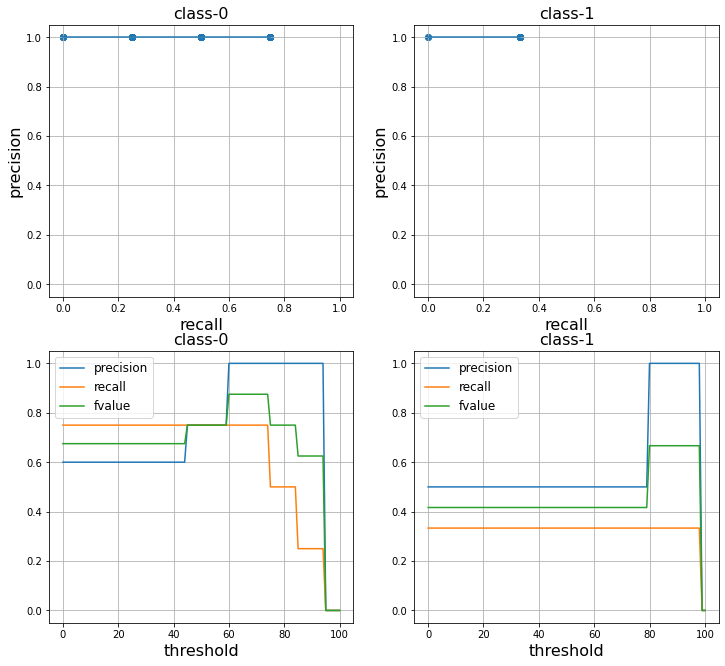

bestScore=0.66, best_threshold=0.74


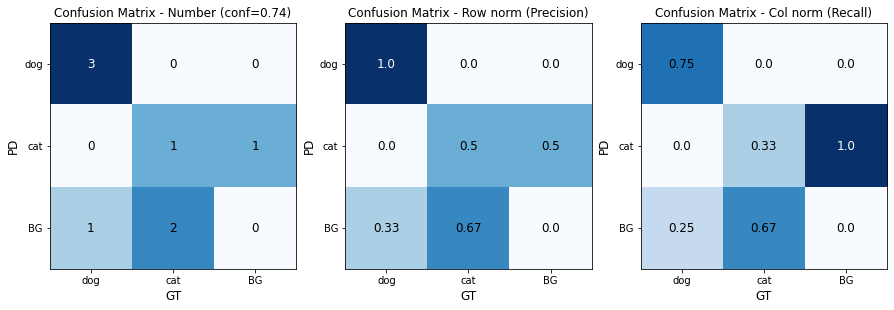

len(glob.glob(folder+'/*.jpg'))=1


In [6]:
os.makedirs(savePath, exist_ok=True)
obj = Result(imgPathL, antPathL, labels, detections, classL, classNumL, savePath)
obj.getPR()
obj.getRefineRP()
obj.getAPs()
obj.plotPR()
obj.plotConfusion()
obj.getBlockImgs(1,2)